# Predicting Stock Price Using Brownian Motion
---

**Dibuat oleh:** 
- Dennis Jonathan (23101910027)

*S1 Business Mathematics 2019 - Universitas Prasetiya Mulya*


**Brownian Motion** is a type of movement which was first observed by physician by the name of Robert Brown in the year of 1827. [Britanica](https://www.britannica.com/science/Brownian-motion) stated that the idea of **Brownian Motion** in physics describes particles that are placed in a given medium which has no preferred direction for random oscillation, over a period of time, the particles will be spread evenly in that medium. Essentially, particles which has **Brownian Motion** has a tendency to undergo some small and randomly occuring fluctuations.

That brings us to the world of mathematics, and to be exact, the world of simulations. The characteristic of this motion turns out to be incredibly useful for simulations, especially the random movement aspect of it. **Brownian Motion** is defined as the existance of a probability distribution over a set of continuous function $B:\mathbb{R}_{\geq 0} \to \mathbb{R}$ such that:

1. $B(0)=0$
2. Stationary for $0\leq s\leq t$, $B(t) - B(s) \sim N(0, t-s)$
3. Independent increment

For this exercise, we will be using two variants of the motion, the first is called as **Brownian Motion with Drift** and the second is called as **Geometric Brownian Motion**. Both simulations will be used on a stock of our choice, for now we will be simulating the **Closing Price** of [Apple.inc](apple.com) with ticker **AAPL**. Our data will be pulled straight from [Yahoo Finance](https://finance.yahoo.com/quote/AAPL/).

## 1. Pre-Requisites

### 1.1. Installing Some Libraries
First of all, we will be installing some libraries which were not available on **Deepnote** (the site which I used to make this notebook), which are `openpyxl` and `xlrd`. We will also need to install `pandas_datareader` to pull our stock prices from the afore mentioned source. To install a library in Python, one need to use `!pip install *name*`. If you are using a **Jupyter Notebook**, there is absolutely no need to install the first two libraries.

In [1]:
# # Installing libraries
# !pip install openpyxl
# !pip install xlrd
# !pip install pandas_datareader

### 1.2. Importing the Necessary Libraries
After installing the libraries, we will need to import them to our notebook. In general, there are four kinds of libraries we will be using, those are:
- Libraries for data processing and mathematics (`pandas` and `numpy`)
- Libraries to scrape the data (`pandas_datareader`)
- Libraries to utilize the datetime capability of Python (`datetime` and `dateutil`)
- Libraries to plot our graph (`matplotlib` and `seaborn`)

The last one (`warnings`) is completely optional. As we are not using all the functions in the library, we only need to import those we actually use.

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader

# Importing Datetime libraries
from datetime import date
from dateutil.relativedelta import relativedelta

# Importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preventing warning pop ups
import warnings
warnings.filterwarnings('ignore')

# Matplotlib settings
%matplotlib inline

### 1.3. Pulling in the Stock Data from Yahoo Finance
One can actually download a `.csv` file straight from Yahoo Finance, but that will not be as fun as scraping the site straight from our notebook. First, you can decide the period of data we want to pull. After that, we will take today's date and call it `end`, then substract it by the period we have previously decided and call it `start`. 

Pulling the data is relatively easy, using `DataReader()`, we just need to input the ticker, the data source, the start and end date. Because we will only need the **Closing Price**, we need to add `['close']` just after the function and add the method `.to_frame()` to make it into a nice and neat dataframe.

In [3]:
# Specify start date and end date
period_year = 1
end = date(2022, 4, 5) # if you want to use today's date, end = date.today()
start = end - relativedelta(years = period_year)

# Specify stocks that you want to get and data source
ticker = ['AAPL']
data_source = 'yahoo'

# Read the data
df = DataReader(ticker[0], data_source, start, end)['Close'].to_frame()
df.drop_duplicates(keep = 'first', inplace = True)

After pulling the data, it is always a good omen to fix our column names. I found that the output dataframe above usually has either the ticker as the column name or "Close", thus we can easily rename them into lower case "close" using `.rename()`. 

We will see the change as well as a glimpse of the first $5$ of our dataset using `.head()` method for a dataframe.

In [4]:
# Renaming our column
df.rename(columns = {ticker[0]:'close', 'Close':'close'}, inplace = True)

# Glimpse of the data
df.head()

,close
Date,
2021-04-05,125.900002
2021-04-06,126.209999
2021-04-07,127.900002
2021-04-08,130.360001
2021-04-09,133.000000


After seeing the first five entries, we can also observe that the index for each entry correspond to the closing price for that particular date. This is good news as we do not need to change the index of our dataframe anymore since stock price is a time series data.

Next up, we can also see the dimension of our data. This will be useful later on as we will need the number of rows to decide the interval for our simulation.

In [5]:
# Previewing the data dimension
print('The data has {p1} rows and {p2} columns'.format(p1 = df.shape[0], p2 = df.shape[1]))

The data has 244 rows and 1 columns


As we can see, our dataset has $244$ rows and $1$ column, which is the closing price. The number of rows could certainly change if the period in the previous cells is also changed.

## 2. Brownian Motion with Drift
We have now reached the first simulation, which is **Brownian Motion with Drift**. This simulation follows a pattern which is

$$X(t) = \mu t + \sigma B(t)\tag{1}$$

Where $X(t)$ is the value for time $t$. $\mu$ is the **average real stock price** which is also called as the **Drift** variable. $\sigma$ is the **standard deviation of the real stock price**. Last but not the least, $B(t)$ is the Brownian Motion at that particular time. 

Essentially, what makes this different from a regular **Brownian Motion** is the presence of the **Drift** variable. The **Drift** variable acts as the gradient or trend, thus a positive value will see an increase and a negative will see a decrease. regular **Brownian Motion** does not have this, thus it fluctuates only around $y = 0$. There are several assumptions for this type of motion, those are:
1. $X(0)=X_0$
2. Stationary for $0\leq s\leq t$, $X(t) - X(s) \sim N(\mu \Delta t, \sigma^2 \Delta t)$ where $\Delta t = \left(t-s\right)$
3. Independent increment

### 2.1. Brownian Motion with Drift Algorithm
To create the **Brownian Motion with Drift** algorithm, we will use the second assumption. Moving the variables around will result in the equation and assuming that $s = (t-1)$

$$X(t)=X(t-1)+N(\mu \Delta t, \sigma^2 \Delta t)\tag{2}$$


where $\Delta t = \left[t-(t-1)\right]$. Thus if we set a point and call it $X_0$, we can iterate through all the data and simulate the movement of the stock price. In order to make this work, we will also need to find the values for $\mu$ and $\sigma$ as mentioned above. 

After doing that, we can also repeat the simulation as much as we want, therefore we also need a metric to measure the performance of each repetition. For this algorithm, we are going to use **Mean Absolute Percentage Error** or **MAPE**. **MAPE** has a formula of

$$\text{MAPE} = \frac{1}{n}  \sum_{i=1}^{n} \left|{\frac{\text{Actual}-\text{Prediction}}{\text{Actual}}} \right| $$

Then using **MAPE**, we can choose the repetition with the best fit to our actual data and return it back to us.

In [6]:
def bm_drift(data, period = 1, seed = False, rep = 1):
    
    # Checking if the seed parameter and setting the random seed if necessary
    if seed  == True:
        np.random.seed(0)
    
    # Defining the constants
    dt = period / len(data)
    mu = np.mean(data)
    sigma = np.std(data)
    
    # Initiating the array of Xs with X0 = data[0]
    X = np.zeros(shape = (1, rep))
    X[0] = data[0]
    
    # Finding the increment using normal distribution with the constants as parameters
    increment = np.random.normal(loc = mu * dt, scale = sigma * np.sqrt(dt), size = (len(data) - 1, rep))
    
    # Combining the array of Xs and the increment
    X = np.concatenate((X, increment), axis = 0)
    
    # Cummulative summing accross all the columns
    X = np.cumsum(X, axis = 0)
    
    # Finding the MAPE
    mape = np.mean(np.abs((X - data.values.reshape((len(data), 1)))/data.values.reshape((len(data), 1))), axis = 0)
    
    # Finding the iteration with the lowest MAPE
    minimum = np.where(mape == mape.min())[0][0]
    
    # Printing and returning the iteration with the lowest MAPE
    print('This is iteration {it} with MAPE {ma}%'.format(it = minimum, ma = round(mape[minimum] * 100, 2)))
    
    # Setup index
    min_res = pd.Series(X[:, minimum])
    min_res.index = data.index
    return min_res

The function `bm_drift()` takes in several parameters, namely:
- `data` : The stock data we are trying to simulate. This expects a **Series**.
- `period`  : The period of the stock data, measured in years. This expects a numeric value.
- `seed`: The value for `Numpy`'s random seed. This is to ensure replicability. This expects a boolean.
- `rep`: The number of repetitions. This expects a numeric value.

The flowchart below illustrates how the algorithm above works:

![Brownian Motion with Drift Algorithm](Diagrams/BM_Drift.png)
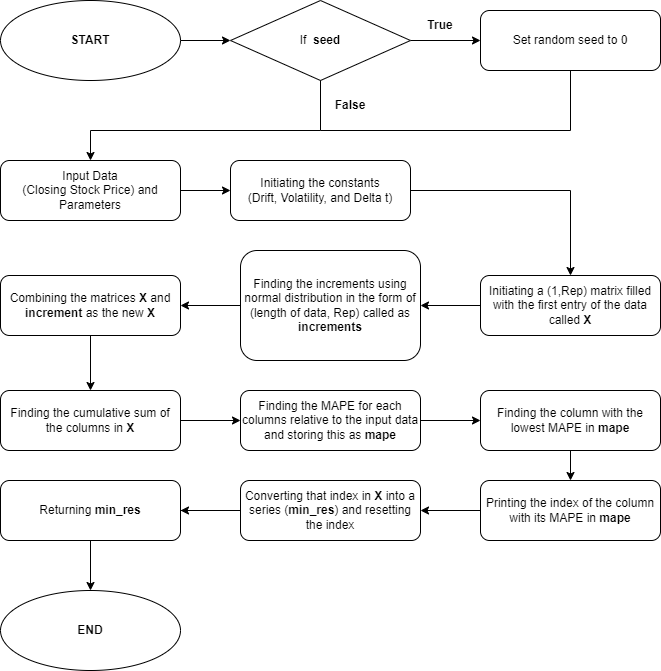

### 2.2. Using the Brownian Motion with Drift for the Closing Price
Next, we will use the function to simulate the closing price of the stock. This in theory should work better as one of the uses of **Brownian Motion with Drift** is to simulate actual prices not returns. We will the use $100,000$ repetition thus `rep = 100000` and use **MAPE** to find the closest line to our actual data

In [7]:
# Using bm_drift to simulate the closing price
drift_close = bm_drift(df['close'], period = period_year, seed = True, rep = 100000)

This is iteration 38284 with MAPE 9.47%


Using the function, we found out that the $38,284\text{th}$ iteration yields the lowest **MAPE**, which is roughly $9.47 \%$. We can also check the result by plotting it relative to the actual closing price and see for ourselves whether the simulation works.

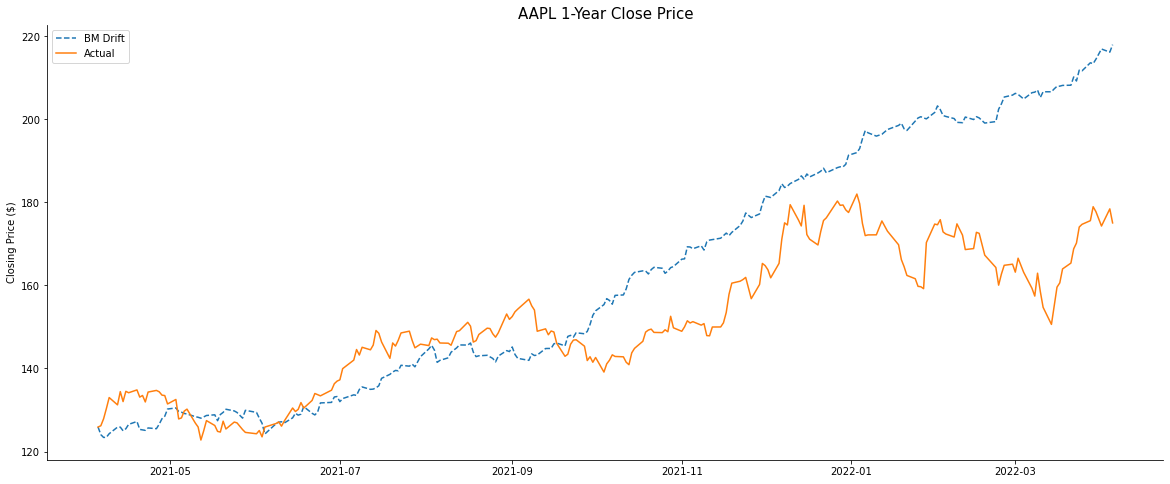

In [8]:
# Setting the figure size
plt.figure(figsize = (20, 8))

# Plotting the data
plt.plot(drift_close, linestyle = 'dashed', label = 'BM Drift')
plt.plot(df['close'], label = 'Actual')

# Plot settings
plt.title('{stock} {period}-Year Close Price'.format(stock = ticker[0], period = period_year), 
          fontsize = 15)
plt.ylabel('Closing Price ($)')
plt.legend()
sns.despine()

# Showing the plot
plt.show()

Unlike the plot for the returns, the closing price simulation is a lot closer to its actual closing price. There are times where it tends to overshoot a little and times where it does not change quickly enough to the movement of the actual price.

## 3. Geometric Brownian Motion

**Geometric Brownian Motion** can be described as **Brownian Motion with Drift** but a lot more sensitive to changes. In the previous section, we have seen that **Brownian Motion with Drift** have a tendency to not change as rapidly, thus this simulation method tries to "fix" the issue. The model itself is defined as:

$$S(t) = e^{X(t)}\tag{3}$$

Where $S(t)$ is the value of the simulation at time $t$ and $X(t)$ is actually the value of the **Brownian Motion with Drift** at the same time $t$. 

### 3.1. Geometric Brownian Motion Algorithm

So you may ask, what makes this different from **Brownian Motion with Drift**. First of all, we will not be using **Equation 4** to actually model the value, instead we will be using either:

$$S(t) = S(t-1)\cdot e^{N(\mu \Delta t, \sigma^2 \Delta t)}\tag{4}$$

or the equation

$$S(t) = S(t-1) \cdot e^{\left[\left(\mu^* - \frac{\sigma^2}{2}\right)\Delta t + \sigma N(0, \Delta t)\right]} \tag{5}$$

Where $\Delta t = [t-(t-1)]$. What makes it also different is how we get $\mu$ and $\sigma$. Several people has interpretations of the exact method, but the common denominator is that we are using the **Geometric Return** to find both variables.

$$\mu^* = \frac{\bar{R}}{\Delta t} + \frac{\sigma^2}{2} \tag{6}$$

$$\sigma = \frac{S}{\sqrt{\Delta t}} \tag{7}$$

Where $\bar{R}$ is the average **Geometric Return** of the stock over the period and $S$ is the standard deviation of the **Geometric Return**. We will also use **MAPE** to find the repetition which is closest to our actual stock price. And just like **Brownian Motion with Drift**, we will also need to find $S_0$.

The formula of a **Geometric Return** is

$$R_t = ln \left(\frac{S_t}{S_{t-1}} \right)\tag{8}$$

Where $R_t$ is the return for time $t$, $S_t$ is the stock price at time $t$ and $S_t$ is the stock price at the time $t-1$.

To get the **Geometric Return** we can use the `np.log()` function and dividing our closing price at time $i$ with that of time $i-1$ (by using `data.shift(1)/data`, but it should be noted that we will need to multiply it with $-1$). 

In [9]:
def geo_bm(data, period = 1, seed = False, rep = 1):
    
    # Checking if the seed parameter and setting the random seed if necessary
    if seed  == True:
        np.random.seed(0)
    
    # Defining the target and the return data
    target = data
    g_return = -np.log(target.shift(1)/target)
    
    # Defining the constants
    dt = period / len(data)
    sigma = np.std(g_return) / np.sqrt(dt)
    mu = np.mean(g_return) / dt + 0.5 * sigma**2
    
    # Initiating an array of Ss with 
    S = np.zeros(shape = (1, rep))
    S[0] = target[0]
    
    # Finding the increment
    increment = np.exp((mu - sigma**2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size = (len(target) - 1, rep)))
    
    # Combining the array of Ss and the increment
    S = np.concatenate((S, increment), axis = 0)
    
    # Finding the cummulative product accros the columns
    S = np.cumprod(S, axis = 0)
    
    # Finding the MAPE
    mape = np.mean(np.abs((S - target.values.reshape((len(target), 1)))/target.values.reshape((len(target), 1))), axis = 0)

    # Finding the iteration with the lowest MAPE
    minimum = np.where(mape == mape.min())[0][0]
    
    # Printing and returning the iteration with the lowest MAPE
    print('This is iteration {it} with MAPE {ma}%'.format(it = minimum, ma = round(mape[minimum] * 100, 2)))
    
    # Setup index
    min_res = pd.Series(S[:, minimum])
    min_res.index = data.index
    return min_res

The function `geo_bm()` takes in several parameters, namely:
- `data` : The stock data we are trying to simulate. This expects a **Series**.
- `period`  : The period of the stock data, measured in years. This expects a numeric value.
- `seed`: The value for `Numpy`'s random seed. This is to ensure replicability. This expects a boolean.
- `rep`: The number of repetitions. This expects a numeric value.

The flowchart below illustrates how the algorithm above works:

![Geometric Brownian Motion Algorithm](Diagrams/Geo_BM.png)
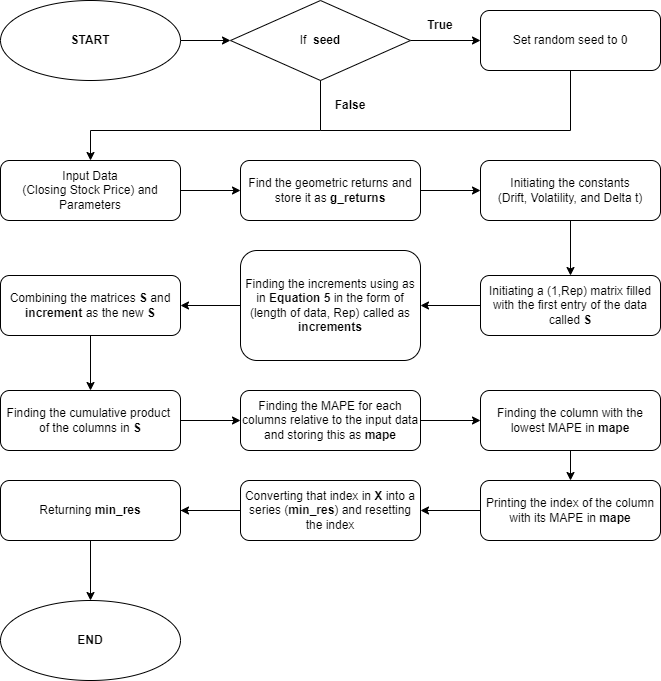

### 3.2. Using the Geometric Brownian Motion for the Closing Price
So now we are going to use the function to simulate the **Closing Price**. This should yield a better simulated set of values compared to the section before. We are going to use exactly the same parameter as what we did in **Section 2.2.**.

In [10]:
# Using the function to simulate the closing price
geo_close = geo_bm(df['close'], period = period_year, seed = True, rep = 100000)

This is iteration 3883 with MAPE 2.94%


We can see that for our $100,000$ iterations, the best iteration is iteration $60,135$ with **MAPE** of roughly $2.94 \%$. This by itself is a lot better than that of **Brownian Motion with Drift** ($9.47 \%$). We can check the figure to see whether our simulation is indeed correct.

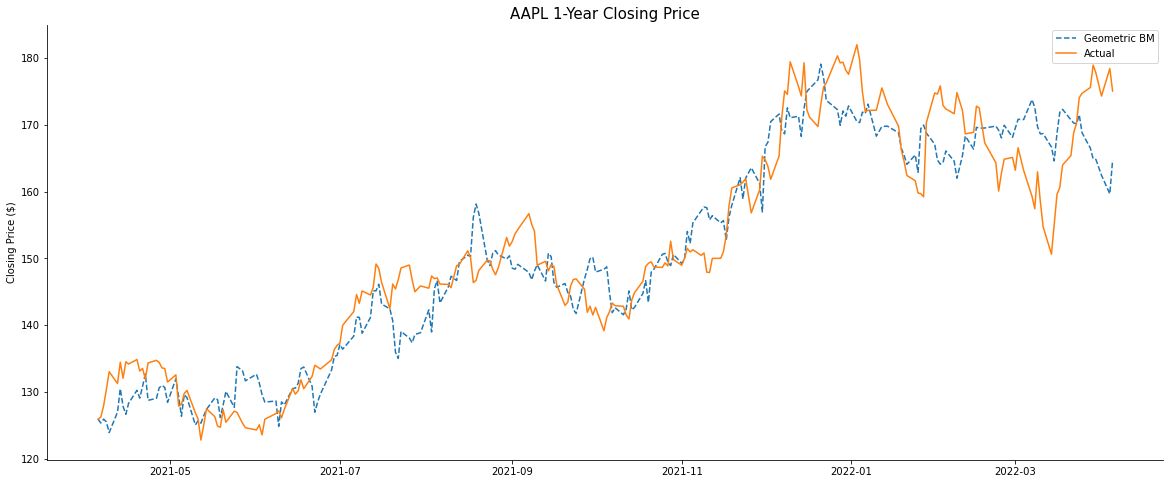

In [11]:
# Setting up the figure
plt.figure(figsize = (20, 8))

# Plotting the data
plt.plot(geo_close, linestyle = 'dashed', label = 'Geometric BM')
plt.plot(df['close'], label = 'Actual')

# Plot settings
plt.title('{stock} {period}-Year Closing Price'.format(stock = ticker[0], period = period_year), 
          fontsize = 15)
plt.ylabel('Closing Price ($)')
plt.legend()
sns.despine()

# Displaying the plot
plt.show()

From the graph above, it is clear to see that our simulation is a lot closer to the actual **Closing Price**. When compared to the result of **Brownian Motion with Drift**, it also changes much more rapidly and has less of the overshooting issue.

## 4. Conclusion
To conclude this exercise, it is clear to see that both of the **Browinian Motion** simulations can actually model **Closing Price** of a stock well, with the **Geometric Brownian Motion** a lot better than **Brownian Motion with Drift**.

## 5. Bibliography

- ASX Portofolio. (2021). *Simulating Geometric Brownian Motion in Python*. Retrieved April 1, 2022, from https://asxportfolio.com/options-stochastic-calculus-simulating-gbm
- Britanica. (n.d.). *Brownian motion | physics*. Encyclopedia Britannica. Retrieved April 1, 2022, from https://www.britannica.com/science/Brownian-motion
- Liden, J. (2018). *Stock Price Predictions using a Geometric Brownian Motion*. Uppsala Universitet. Retrieved April 1,2022, from
https://www.diva-portal.org/smash/get/diva2:1218088/FULLTEXT01.pdf
- Maulidya, V., et.al. (2020). *Prediksi Harga Saham Menggunakan Geometric Brownian Motion Termodifikasi Kalman Filter dengan Konstrain*. Indonesian Journal of Applied Mathematics Retrieved April 1, 2022, from https://journal.itera.ac.id/index.php/indojam/article/view/307/111
- Reddy, K. & Clinton, V. (2016). *Simulating Stock Prices Using Geometric Brownian Motion: Evidence from Australian Companies*. Australasian Accounting, Business and Finance Journal, 10(3). https://doi.org/10.14453/aabfj.v10i3.3
